# Neural Networks for Data Science Applications (2019/2020)
## Final exam Presentation

* **Student(s)**: Vikranth Ale (1873995) , Kentaro Kato (1851049)
* **Reference paper / topic**: Erik Cambria, Soujanya Poria Et al., MAR/APR 2017. AFFECTIVE COMPUTING AND SENTIMENT ANALYSIS : Deep Learning - Based Document Modeling for Personality Detection from Text.  [*Reference Link*](https://sentic.net/deep-learning-based-personality-detection.pdf)




# Part 1: Report

This research paper is mainly focussed with the idea on how we can identify and extract different personality traits of a person from a stream of consciousness essays using convolutional neural network (CNN). It is because automatic detection of a person’s personality traits has many practical applications, using sentiment analysis we can understand the types of products or services a person might be interested, word polarity disambiguation to convey polarity of different types of people, we can also correlate certain kind of medical health diagnosis with certain personality traits and many more use cases. 

In this paper the authors introduced a novel document modeling technique based on extracting CNN features by feeding sentences from the essays to convolution filters to obtain a sentence model in the form of n-gram feature vectors and then each individual essay by aggregating the vectors of its sentences. Finally by discarding the emotionally neutral input sentences and by concatenating the obtained document vectors with the Mairesse features extracted from the texts is fed to a fully connected neural network for final classification, this technique improved the method’s performance and results.


**The following are the mathematical forms for the functions we used to build our model:**

+ Generalized form of Cost Function for Multi-Class Classification Model with Regularization:
\begin{equation}
J(\theta) = \frac{-1}{m}[\sum_{i=1}^{m} y^{(i)} logh_{\theta}(x^{(i)}) + (1 - y^{(i)} log( 1- h_{\theta}(x^{(i)}))] + \frac{\lambda}{2m} \sum_{i=1}^{n} \theta_{j}^{2}
\end{equation}

Here *m* is Number of samples and $h_{\theta}(x^{(i)})$ is hypothesis
where as $\lambda$ is a regularization parameter and $\theta$ is a bias/weights term

We used Regularization for our learning algorithm to prevent overfitting and to generalize the model in a better way so as to improve model performance on test data as well.


+ Cost Function for Neural Network:
\begin{equation}
h(\Theta) \in R^{K} ,   (h_{\Theta}(x))_{i} = i^{th} output \\
J(\theta) = \frac{-1}{m}\sum_{i=1}^{m} \sum_{k=1}^{K} y_{k}^{(i)} log(h_{\theta}(x^{(i)}))_{k} 
\end{equation}

Here **K** is the Number of classes in the final output layer and **$h{(x)}$** is a k-dimensional vector

+ Rectified Linear Unit [ReLu]:
\begin{equation}
 f(x) =
\begin{cases}
     x      & \quad \text{if } x > 0 \\
     0      & \quad \text{if } x <=0
\end{cases}
\end{equation}

+ Sigmoid Function:
\begin{equation}
 f(x) =  \frac{1}{1 + \exp(-x)}
\end{equation}


+ SoftMax Function:
\begin{equation}
Softmax(x_{i})  = \frac{\exp(x_{i})}{\sum_{j=1}^{n}\exp(x_{j})}
\end{equation}


+ Adadelta Optimizer with Learning rate ($\rho$) :
\begin{equation}
x_{t} = x_{t-1} - g_{t}^{'} \\
\Delta x_{t} = \rho \Delta x_{t-1} + (1 - \rho) x_{t}^{2}
\end{equation}

Here $ g_{t}^{'} $ is the rescaled gradient which is computed by taking the ratio between the average squared rate of change and the average second moment of the gradient

$\Delta x_{t}$  to store a leaky average of the second moment of the change of parameters in the model 



# Part 2: External libraries



In [0]:
# We use tensorflow 2.0 with gpu support
!pip -q install tensorflow-gpu==2.0.0

# Get access for Google word2vec
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

     |████████████████████████████████| 380.8MB 43kB/s 
     |████████████████████████████████| 3.8MB 62.1MB/s 
     |████████████████████████████████| 450kB 63.0MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
--2020-02-22 19:41:48--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.82.83
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.82.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  87.8MB/s    in 38s     

2020-02-22 19:42:26 (41.8 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.b

In [0]:
import warnings
warnings.filterwarnings("ignore")

# preprocessing ---------
import pandas as pd
import numpy as np
from collections import defaultdict
import csv
import re
import gensim
import pickle

# CNN ---------------------
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Activation, TimeDistributed
from tensorflow.keras.layers import Input, Embedding, Dense, Reshape, Dropout,concatenate, BatchNormalization
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import SGD, Adadelta
from keras import regularizers
import tensorflow.keras.backend as K

# Plotting ----------------
import matplotlib.pyplot as plt

In [0]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/BI/Vicky_Ken/NeuralNetworks_Proj/data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Part 3: Code
# Preprocessing

## External data
First, we load all external data

**Essay**

- Extroversion (EXT). 
    Is the person outgoing, talk- ative, and energetic versus reserved and solitary?
- Neuroticism (NEU). Is the person sensitive and nervous versus secure and confident?
- Agreeableness (AGR). Is the person trustworthy, straightforward, generous, and modest versus unreliable, complicated, and boastful?
- Conscientiousness (CON). Is the person effi- cient and organized versus sloppy and careless?
- Openness (OPN). Is the person inventive and cu- rious versus dogmatic and cautious?

In [0]:
essays = pd.read_csv(path + 'essays.csv', encoding = "ISO-8859-1")

# sort by the name of documents to extract exactly same names of mairesse files
essays = essays.sort_values(by='#AUTHID').reset_index(drop=True)

print(essays.shape)
essays.head(1)

(2467, 7)


,#AUTHID,TEXT,cEXT,cNEU,cAGR,cCON,cOPN
0,1997_012113.txt,The lights are all out here in Hardin House. ...,y,n,y,y,n



**Mairesse**

a document-level feature set for personality detection, cosisting of 84 features.

For example, word count and average number of words per sen- tence, as well as the total number of pronouns, etc.

In [0]:
df_mairesse = pd.read_csv(path + 'mairesse.csv', header=None, encoding = "ISO-8859-1")

# sort by the name of documents to extract exactly same names of essay files
df_mairesse = df_mairesse.sort_values(by=0).reset_index(drop=True)

print(df_mairesse.shape)
df_mairesse.head(1)

(2467, 85)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84
0,1997_012113.txt,-0.906225,-0.282501,0.804554,-0.550804,0.175804,1.416255,-0.183624,-0.085071,-0.273498,-0.003515,-0.222462,-0.373079,-0.143331,-0.404052,0.124246,0,-0.04277,-0.029669,-1.427898,0.645842,-1.332624,-0.742368,1.531386,-1.073173,-0.624052,0.161666,-0.19206,-0.515408,-0.222086,0.250951,-0.74627,-0.739476,-0.579416,-0.48731,-0.163903,-0.353006,-0.829634,0.832242,-0.711506,...,1.805426,-0.208015,0.75071,0.775876,-0.302782,1.204214,0.173573,0.596455,-0.25732,-0.057862,-0.846183,0.707897,1.133445,-0.314338,0.137457,-0.45325,0.032673,-0.689239,-0.027354,-0.333155,-0.136999,-0.280398,-0.086094,1.006282,-1.001457,-0.073676,-0.23436,-0.330042,-0.37208,-0.337085,-0.422267,0.744863,-0.451544,0.1333,0.226499,4.618658,3.369903,5.000089,4.670976,4.714842


**Google word2vec**

Google's pre-trained word2vec embeddings

In [0]:
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'
w2v_google = gensim.models.KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

vacab_dict = w2v_google.vocab
vacab_google = vacab_dict.keys()

print('{} words'.format(len(set(vacab_google))))

3000000 words


**Emotion Lexicon**

This contains 14,182 words tagged with 10 attributes: anger, antici- pation, disgust, fear, joy, negative, posi- tive, sadness, surprise, and trust.

We obtain only emotionally charged words.

In [0]:
print('Loading emotion Lexicon data')
lex = pd.read_csv(path + 'Emotion_Lexicon.csv')
print("Total Number of words in Emotion Lexicon: {}".format(lex.shape[0]))

# Extract the only words containin emotional meaning
charged_words=[]
for i in range(len(lex)):
    if lex.iloc[i, :]['Charged'] == 1:
        charged_words.append(lex.iloc[i, :]['Words'])
charged_words = set(charged_words)

print("Total Number of Charged Words found\t:  {}".format(len(charged_words)))
lex.head(1)

Loading emotion Lexicon data
Total Number of words in Emotion Lexicon: 14182
Total Number of Charged Words found	:  6468


,Words,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,Charged
0,march,0,0,0,0,0,0,1,0,0,0,1


## Functions for preprocessing

In [0]:
# definition for cleaning sentences and extracting required features ------------------------------------------------------------------------------

def clean_str(string):
    """
    A function for cleaning sentences.
    Extends one shortened word to 2 words  (i.e. i'm -> I am, you're -> you are) 
    Removes all words which are not numbers and alphabet
    """
    string = re.sub(r"\'s", " \'s ", string)
    string = re.sub(r"\'m", " am ", string)
    string = re.sub(r"\'ve", " have ", string)
    string = re.sub(r"n\'t", " not ", string)
    string = re.sub(r"\'re", " are ", string)
    string = re.sub(r"\'d" , " would ", string)
    string = re.sub(r"\'ll", " will ", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " ( ", string)
    string = re.sub(r"\)", " ) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"[^A-Za-z0-9\'\`]", " ", string)
    
    return string.strip().lower()

# extract documents information --------------------------------------------------------------------------------
def get_documents(documents, n, n_cv = 5):
    """
    A function to save information for each document
    The information obtained here is:
        Personality traits(True or False)
        Sentences
        Name of document,
        The maximum number of words overall sentences (the longest sentences)
        The number of sentences
        CV number (0~4)
    """
    revs = []
    vocab = defaultdict(float)
    for i in range(len(documents)):
        
        if len(revs) == n: # To obtained desired number of documents
            break
                
        doc = documents.iloc[i, :]
        sentences = doc['TEXT']
        sentences = re.split(r'[.?]', sentences)  # split senteces by '.' of '?'    

        sentences_in_doc = []
        max_sent = 0 # max length of sentence
        
        for sent in sentences:
            orig_rev = clean_str(sent.strip()) # clean the sentence
            
            if len(orig_rev) == 0: 
                continue
                
            words = set(orig_rev.split())  # words shown in the sentence
            splitted = orig_rev.split()  
            
            if len(splitted)>150:  # To prevent ceating too big matrix for NN
                orig_rev=[]
                splits=int(np.floor(len(splitted)/20)) # How many parts to split the sentence
                for index in range(splits):
                    orig_rev.append(' '.join(splitted[index*20:(index+1)*20]))
                if len(splitted)>splits*20: # The last part of the splitted sentence
                    orig_rev.append(' '.join(splitted[splits*20:]))
                sentences_in_doc.extend(orig_rev)
            else:
                sentences_in_doc.append(orig_rev)
            
            for word in words:
                vocab[word] += 1  # Count the occurance of words(vocabulary)
            
        max_sent = np.max([len(sent.split()) for sent in sentences_in_doc])    # the longest sentences
        true, false = [1,0], [0,1]  

        doc_data  = {"y0":true if doc['cEXT'].lower()=='y' else false,
                      "y1":true if doc['cNEU'].lower()=='y' else false,
                      "y2":true if doc['cAGR'].lower()=='y' else false,
                      "y3":true if doc['cCON'].lower()=='y' else false,
                      "y4":true if doc['cOPN'].lower()=='y' else false,
                      "text": sentences_in_doc,
                      "user": doc['#AUTHID'],
                      "max_words": max_sent,
                      "num_sents": len(sentences_in_doc),
                      "split": np.random.randint(0, n_cv) # For cross validation to split train and test
                      } 

        revs.append(doc_data)

    return revs, vocab

def create_word2vec(w2v_google, vocab):
    """
    Creates word2vec for shown words in our documents
    """
    vocabs = list(vocab.keys())
    w2v = {}
    for word in vocabs:
        try: # If the word can be found in google w2v
            w2v[word] = w2v_google[word]
        except: # Otherwise....
            """
            0.25 is chosen for unknown vecotrs
            so the unknown vectors have (approximately) same variance as pre-trained ones
            """
            X = 1
            if vocab[word] >= X:
                w2v[word] = np.random.uniform(-0.25,0.25, 300)
            continue
            
    return w2v

def get_W(word_vecs, k=300):
    """
    Creates a matrix of word2vec (first row is all zeros)
    W[i] is the vector for word indexed by i
    Also creates a word-idx mapping corresponding to the index or obtained matrix
    """
    vocab_size = len(word_vecs)
    word_idx_map = dict()
    W = np.zeros(shape=(vocab_size+1, k))
    W[0] = np.zeros(k)  # set all zeros on the first row
    i = 1
    for word in word_vecs:
        W[i] = word_vecs[word]
        word_idx_map[word] = i
        i += 1
    return W, word_idx_map

# extract our chosen documents and create dictionary
def get_mairesse_features(file, n):
    """
    Obtains for desired number of  mairesse file

    """
    features = {}
    for i in range(len(file)):
        data = file.iloc[i, :]
        features[data[0]] = [float(f) for f in data[1:]]
        
        if len(features) == n:
            break
        
    return features

### Now we run the functions to obtain desired number of document dataset

In [0]:
n = int(input("How many documents(Maximum : 2467)? \n"))
if n > 2467: n = 2467
n_cv = int(input("How many cv(Maximum : 10)? \n"))
if n_cv > 10 : n_cv = 10

revs, vocab = get_documents(essays, n, n_cv)
print('{} documents, {} vocabularies'.format(len(revs), len(vocab)))

N_SENT = 0
N_WORD = 0
for rev in revs:
    num_sent = rev['num_sents']
    num_words = rev['max_words']
    if num_sent > N_SENT:
        N_SENT = num_sent
    if num_words > N_WORD:
        N_WORD = num_words
print('max number of sentences in all documents',N_SENT )
print('max words in sentences in all documents',N_WORD )

w2v = create_word2vec(w2v_google, vocab)
W, word_idx_map = get_W(w2v)

mairesse = get_mairesse_features(df_mairesse, n)

How many documents(Maximum : 2467)? 
1000
How many cv(Maximum : 10)? 
5
1000 documents, 18490 vocabularies
max number of sentences in all documents 221
max words in sentences in all documents 149


## Functions to extract only the meaningful data from the whole dataset

In [0]:
def get_idx_from_sent(sentences, 
                        word_idx_map, 
                        charged_words, 
                        N_WORD,  # max_num_words
                        N_SENT,   # max_num_sent
                        filter_h, 
                        k):
    """
    Transforms sentence into a list of indices 
    Pad with zeroes
    """
    x = []
    pad = filter_h - 1  # padding size
    num_sentences = len(sentences) 

    pass_one=True
    while len(x)==0: 
            
        for i in range(num_sentences):
            words = sentences[i].split()
            if pass_one:
                words_set = set(words)
                if len(charged_words.intersection(words_set))==0: # there is no emotional words in this sentence
                    continue
                    
            y=[]
            for i in range(pad):
                y.append(0)     # fill 0 on the left-padding
            for word in words:
                if word in word_idx_map:
                    y.append(word_idx_map[word])

            while len(y) < N_WORD+2*pad:
                y.append(0)   # fill 0 on the right-padding
            x.append(y)

    if len(x) < N_SENT: # to make fixed-length sentence vectors
        x.extend([[0]*(N_WORD+2*pad)]*(N_SENT-len(x)))
        # [max_l+2*pad] is the number of 0s
        # [max_s-len(x)] is the number of lack sentences in this documents

    return x

def create_dataset(revs, word_idx_map, charged_words, N_WORD, N_SENT, filter_h,cv = 0,per_attr = 0, k = 300):
    """
    Splits all dataset into trainset and testset with specific personality trait
    By using the cv number in reviews

    """
    trainX, testX, trainY, testY, mTrain, mTest = [], [], [], [], [], []
    for rev in revs:
        sentences = rev['text']
        # change words in sentences into index of words
        idx_sentences = get_idx_from_sent(sentences, 
                                            word_idx_map, 
                                            charged_words, 
                                            N_WORD, 
                                            N_SENT, 
                                            filter_h, 
                                            k)

        # Split train and test
        if rev["split"] == cv:
            testX.append(idx_sentences)
            testY.append(rev['y'+str(per_attr)])
            mTest.append(mairesse[rev["user"]])
        else:
            trainX.append(idx_sentences)
            trainY.append(rev['y'+str(per_attr)])
            mTrain.append(mairesse[rev["user"]])

    # convert to tensor
    trainX = tf.convert_to_tensor(trainX, dtype=tf.float32)
    trainY = tf.convert_to_tensor(trainY, dtype=tf.float32)
    testX = tf.convert_to_tensor(testX, dtype=tf.float32)
    testY = tf.convert_to_tensor(testY, dtype=tf.float32)
    mTrain = tf.convert_to_tensor(mTrain, dtype=tf.float32)
    mTest = tf.convert_to_tensor(mTest, dtype=tf.float32)

    return trainX, testX, trainY, testY, mTrain, mTest

## Splitting the data into Training and Test sets along with Mairesse features

In [0]:
filter_h = 3   # filter size -> padding size
cv = 3 
per_attr = 0

trainX, testX, trainY, testY, mTrain, mTest = create_dataset(revs, 
                                                            word_idx_map, 
                                                            charged_words, 
                                                            N_WORD, 
                                                            N_SENT, 
                                                            filter_h, 
                                                            cv, 
                                                            per_attr, 
                                                            k = 300)

print('Shape of Training Test \t\t\t\t\t: {}'.format(trainX.shape))
print('Total Number of documents in Training Test \t\t: {}'.format(trainX.shape[0]))
print('Maximum Number of sentences in Training Test \t\t: {}'.format(trainX.shape[1]))
print('Maximum Number of words in Training set (with padding)  : {}'.format(trainX.shape[2]))
print("")
print('Number of Rows in Train set\t: {}'.format(trainX.shape[0]))
print('Number of Rows in Test set \t: {}'.format(testX.shape[0]))
print("")
print('Overall Dimensions of the Splitted Data for Train, Test & Mairesse')
print(trainX.shape, trainY.shape, testX.shape, testY.shape, mTrain.shape, mTest.shape)

Shape of Training Test 					: (824, 221, 153)
Total Number of documents in Training Test 		: 824
Maximum Number of sentences in Training Test 		: 221
Maximum Number of words in Training set (with padding)  : 153

Number of Rows in Train set	: 824
Number of Rows in Test set 	: 176

Overall Dimensions of the Splitted Data for Train, Test & Mairesse
(824, 221, 153) (824, 2) (176, 221, 153) (176, 2) (824, 84) (176, 84)


#### Finally, Our Dataset is ready ! and everything set for feeding it to our Neural Network for Classification

## **Building the Neural Network Architecture**

## Defining our Loss Function for Multi-class classification problem

In [0]:
# Negative log likelihood
def negative_log_likelihood(y_true, y_pred):
  """
  Minimizing the negative log-likelihood of our data with respect to θ given a Gaussian prior on θ 
  is equivalent to minimizing the binary cross-entropy (i.e. binary log loss) between the observed y 
  and our prediction of the probability thereof, plus the squared sum of (the elements of) θ itself.
  """
  return -K.mean(y_true * K.log(y_pred))

In [0]:
# Required number of Documents,Sentences,Words and Mairesse features
N_WORD = trainX.shape[2]
print('Number of WORDS \t:',N_WORD)
N_SENT = trainX.shape[1]
print('Number of SENTENCES \t:',N_SENT)
N_DOC = trainX.shape[0]
print('Number of DOCUMENTS \t:',N_DOC)
N_MAI = mTrain.shape[1]
print('Number of MAIR_FEATURES :',N_MAI)
vocab_size = len(W)
print("Number of words in Vocab:",vocab_size)

Number of WORDS 	: 153
Number of SENTENCES 	: 221
Number of DOCUMENTS 	: 824
Number of MAIR_FEATURES : 84
Number of words in Vocab: 18491


In [0]:
# Defining a function to build our network 

def building_nn_model(N_SENT,N_WORD,N_MAI,same_params = False, show_model = False):

    #Embedding Layer 
    embedding_layer = Embedding(vocab_size, 300,  weights=[W], input_length=N_WORD, trainable=True)
  
    # WORD VECTORIZATION -------------------------------------------------------
    
    # Words level attention model
    word_input = Input(shape=(N_WORD,), dtype='float32')
    embedding_layer = embedding_layer(word_input)
    

    # Unigram 
    unigram = Conv1D(filters=200, kernel_size=1, activation='relu', use_bias=True,name='Unigrams')(embedding_layer)
    unigram = GlobalMaxPooling1D()(unigram)
    unigram = Dropout(0.5)(unigram)


    # Bigram
    bigram = Conv1D(filters=200, kernel_size=2, activation='relu', use_bias=True,name='Bigrams')(embedding_layer)
    bigram = GlobalMaxPooling1D()(bigram)
    bigram = Dropout(0.5)(bigram)

    # Trigram
    trigram = Conv1D(filters=200, kernel_size=3, activation='relu', use_bias=True,name='Trigrams')(embedding_layer)
    trigram = GlobalMaxPooling1D()(trigram)
    trigram = Dropout(0.5)(trigram)

    # Concatenation Layer 
    merged_ngrams = concatenate([unigram, bigram, trigram],axis=1, name="WordVectors")
    
    # Creating Word Model with Input and Output 
    wordEncoder = Model(word_input, merged_ngrams , name="WORD_VECTORIZATION_N_GRAMS") 

    # SENTENCE VECTORIZATION ---------------------------------------------------
    
    # Sentence level attention model
    sent_input = Input(shape=(N_SENT, N_WORD,), dtype='float32')

    # Aggregating Words into Sentences, Sentence into Documents
    sent_encoder = TimeDistributed(wordEncoder)(sent_input)

    # IMPORTANT: applying convolution for concatenation layer 
    sent_encoder = Conv1D(filters=600,kernel_size=1,use_bias=True,
                            kernel_regularizer=regularizers.l2(0.001),
                            activity_regularizer=regularizers.l1(0.001),
                            trainable=True,name="Sent_Convolution")(sent_encoder)
    sent_encoder = BatchNormalization()(sent_encoder)  
    sent_encoder = Activation('relu')(sent_encoder)

    # Document Vectorization ---------------------------------------------------
    #Document Vectors 
    d_network = GlobalMaxPooling1D(name="Document_network")(sent_encoder)

    # Mairesse Features --------------------------------------------------------
    d_mairesse_input = Input(shape = (N_MAI, ), dtype='float32', name='Mairesse_features_input')

    # Concatenate document vector and mairesse
    d_vector_merged = concatenate([d_network, d_mairesse_input],axis=1,name="DocumentVectors")

    """ Regularization
    We apply kernel_regularizer to reduce the weights(W) which are very large causing the network to overfit, after applying kernel_regularizer the weights will become smaller.
    
    Activity_regularizer tries to make the layers output y smaller so as to remove overfitting, it will reduce weights and adjust bias, so y is smallest or closer to zero.

    """
    
    # Fully connected Network for Classification
    d_vector_fc = Dense(200, use_bias=True,
                        kernel_regularizer=regularizers.l2(0.001),
                        activity_regularizer=regularizers.l1(0.001),
                        name="Dense_200")(d_vector_merged)
    d_vector_fc = BatchNormalization()(d_vector_fc)  
    d_vector_fc = Activation('sigmoid')(d_vector_fc) 
    
    # Dropout with 0.5 to avoid overfitting 
    d_vector_fc = Dropout(0.5, name="Dropout_0.5")(d_vector_fc)

    # classification 
    d_output_class = Dense(2,activation='softmax',name="Final_Classification")(d_vector_fc)

    # builidng model
    model = Model(inputs=[sent_input, d_mairesse_input], outputs=[d_output_class],name="SENTENCES_DOCUMENTS_VECTORIZATION")

    #Adding weights to our document vector for sharing the network parameters
    #If we use the same parameters for both convolution layers
    if same_params:
        params = wordEncoder.get_weights()[1:] # first one is embedding parameter
        weights =  []
        bias = []
        for i in range(len(params)):
        
        if i % 2 == 0: # weights
            w = [weight for weight1 in params[i] for weight2 in weight1 for weight in weight2]
            weights.extend(w)
        else: # bias
            bias.extend(params[i])

        weights,  bias = np.asarray(weights), np.asarray(bias)
        weights = np.reshape(weights, (1, 600, 600))
        params = np.array([weights, bias], dtype=object)
        params = np.array([np.array(x) for x in params])
        model.layers[2].set_weights(params)  #layer[2] is the second convolution layer

    
    # OPTIMIZER FUNCTION
    # SGD with Adadelta Optimizer 
    adadelta = Adadelta(learning_rate=0.9, rho=0.95)

    # Compile the Neural Network with Optimization and Loss Functions

    model.compile(optimizer=adadelta, loss=negative_log_likelihood, metrics=['accuracy'])

    # Printing the Model Summary 
    if show_model:
        print("")
        print("PRINTING THE NEURAL NETWORK ARCHITECTURE ")
        wordEncoder.summary()
        model.summary()
      
    return wordEncoder,model

In [0]:
wordEncoder, model = building_nn_model(N_SENT,N_WORD,N_MAI,same_params=True,show_model=True)


PRINTING THE NEURAL NETWORK ARCHITECTURE 
Model: "WORD_VECTORIZATION_N_GRAMS"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 153)]        0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 153, 300)     5547300     input_19[0][0]                   
__________________________________________________________________________________________________
Unigrams (Conv1D)               (None, 153, 200)     60200       embedding_9[0][0]                
__________________________________________________________________________________________________
Bigrams (Conv1D)                (None, 152, 200)     120200      embedding_9[0][0]                
______________________________

## **VISUALIZATION OF ARCHITECTURE**

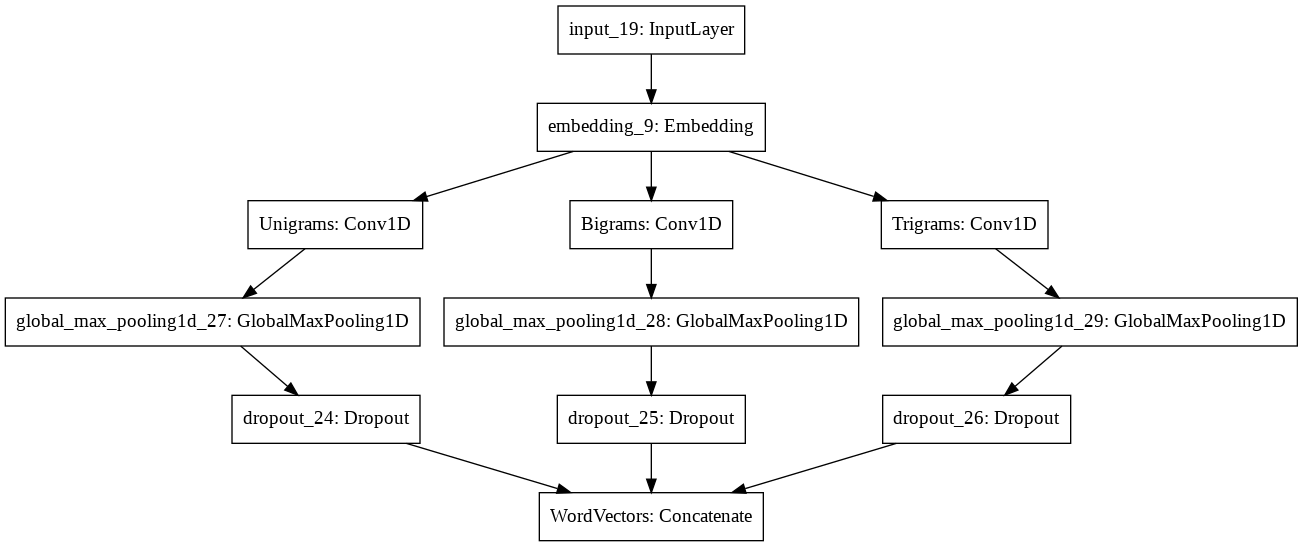

In [0]:
# MODEL VISUALISATION FOR WORD VECTORIZATION

tf.keras.utils.plot_model(wordEncoder)

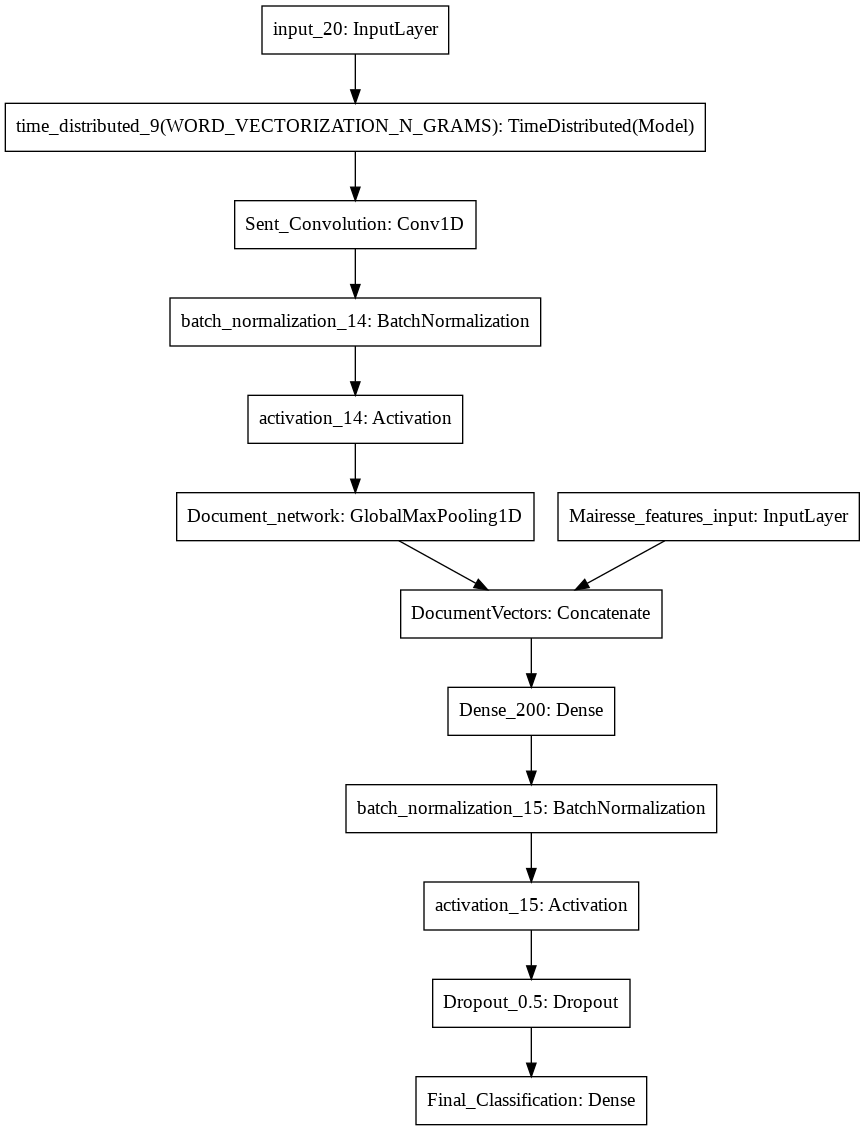

In [0]:
# MODEL VISUALISATION FOR SENTENCES & DOCUMENTS VECTORIZATION

tf.keras.utils.plot_model(model)

Now that our Neural Network Architecture is built, we first want to do train our model and perform classification for only single personality trait and then evaluate our model performance.

In [0]:
# TRAINING THE MODEL for Single Personality Trait

history = model.fit([trainX, mTrain], trainY, epochs=30, batch_size=32, validation_data=([testX, mTest], testY))

Train on 824 samples, validate on 176 samples
Epoch 1/30
824/824 [==============================] - 33s 40ms/sample - loss: 4.3723 - accuracy: 0.5158 - val_loss: 2.3466 - val_accuracy: 0.4659
Epoch 2/30
824/824 [==============================] - 29s 35ms/sample - loss: 2.7120 - accuracy: 0.5328 - val_loss: 1.9086 - val_accuracy: 0.4886
Epoch 3/30
824/824 [==============================] - 29s 35ms/sample - loss: 2.0983 - accuracy: 0.6214 - val_loss: 1.6685 - val_accuracy: 0.5852
Epoch 4/30
824/824 [==============================] - 29s 35ms/sample - loss: 1.8051 - accuracy: 0.6650 - val_loss: 1.5693 - val_accuracy: 0.5625
Epoch 5/30
824/824 [==============================] - 29s 35ms/sample - loss: 1.6003 - accuracy: 0.7718 - val_loss: 1.4742 - val_accuracy: 0.5398
Epoch 6/30
824/824 [==============================] - 29s 35ms/sample - loss: 1.4074 - accuracy: 0.8604 - val_loss: 1.3906 - val_accuracy: 0.6023
Epoch 7/30
824/824 [==============================] - 29s 35ms/sample - loss: 

For 30 epochs, we achieved close to 97 percent accuracy which is very close to that of the results published in the paper.

Now we want to extend our model functionality by including all personality types and evaluate our model performance both on training and validation sets.

## **Final Classification for All 5 Personalities Traits [EXT,NEU,AGR,CON,OPN]**

In [0]:
# Funcion to create dataset for each personality and train the model

filter_h = 3

def CNN(per_attr):
    
    trainX, testX, trainY, testY, mTrain, mTest = create_dataset(revs, 
                                                                word_idx_map, 
                                                                charged_words, 
                                                                N_WORD, 
                                                                N_SENT, 
                                                                filter_h, 
                                                                cv, 
                                                                per_attr, 
                                                                k = 300)

    N_WORD_vec, N_SENT_vec = trainX.shape[2], trainX.shape[1]
    pre_model, model = building_nn_model(N_SENT_vec, N_WORD_vec, 84, same_params=True, show_model=False)
    history = model.fit([trainX, mTrain], trainY , batch_size = 32, epochs=20, verbose = 1)
    val_score = model.evaluate([testX, mTest], testY, verbose = 0)
    return history,val_score[1], 

pers = {0: 'EXT', 1: 'NEU', 2: 'AGR', 3: 'CON' ,4: 'OPN'}
pers_acc = {}
histories = []

for per_attr in range(5):    
    print('')
    print('personality: {}'.format(pers[per_attr]))

    history,val_acc = CNN(per_attr)
    histories.append(history)
    pers_acc[pers[per_attr]] = val_acc


personality: EXT
Train on 824 samples
Epoch 1/20
824/824 [==============================] - 34s 42ms/sample - loss: 4.4280 - accuracy: 0.5085
Epoch 2/20
824/824 [==============================] - 28s 33ms/sample - loss: 2.7156 - accuracy: 0.5303
Epoch 3/20
824/824 [==============================] - 28s 33ms/sample - loss: 2.1024 - accuracy: 0.5874
Epoch 4/20
824/824 [==============================] - 27s 33ms/sample - loss: 1.8198 - accuracy: 0.6481
Epoch 5/20
824/824 [==============================] - 27s 33ms/sample - loss: 1.6010 - accuracy: 0.7597
Epoch 6/20
824/824 [==============================] - 27s 33ms/sample - loss: 1.4327 - accuracy: 0.8252
Epoch 7/20
824/824 [==============================] - 28s 33ms/sample - loss: 1.2802 - accuracy: 0.9102
Epoch 8/20
824/824 [==============================] - 28s 33ms/sample - loss: 1.1867 - accuracy: 0.9211
Epoch 9/20
824/824 [==============================] - 28s 33ms/sample - loss: 1.0967 - accuracy: 0.9296
Epoch 10/20
824/824 [====

Our Model achieved accuracies between 96-98 percent for all the 5 personality traits on training !

## Part 4 - Experimental evaluation

### Here is the plot of accuracy and loss of train and validation set for the first personality 'EXT'


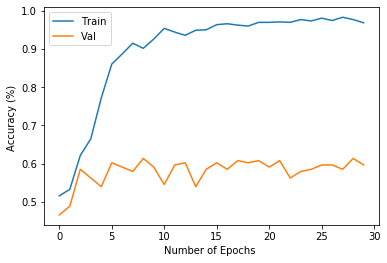

In [0]:
# Plotting the accuracy for One Personality Trait

plt.plot(history.history['accuracy'],label='Train')
plt.plot(history.history['val_accuracy'],label='Val')
plt.xlabel('Number of Epochs ')
plt.ylabel('Accuracy (%) ')
plt.legend()
plt.show()

The accucracy on train set shows a increasing trend as we number of epochs increases while the accuracy on validation data remains between 50 - 60 % with some fluctuations.

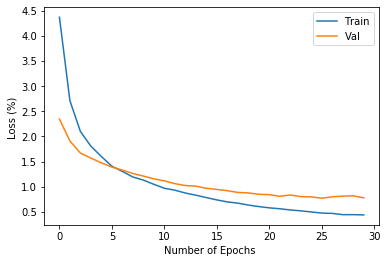

In [0]:
# Plotting the Loss for One Personality Trait

plt.plot(history.history['loss'],label='Train')
plt.plot(history.history['val_loss'],label='Val')
plt.legend()
plt.xlabel('Number of Epochs ')
plt.ylabel('Loss (%) ')
plt.show()

From the above plot we can observe that Loss decreases for both train and validation sets as the number of epochs increases. 

## **Final results on Test Data**

In [0]:
# Final results on Test Data
per_type = pd.DataFrame(pers_acc.items(),columns=['Personality','Accuracy'])
per_type

,Personality,Accuracy
0,EXT,0.556818
1,NEU,0.562500
2,AGR,0.500000
3,CON,0.585227
4,OPN,0.522727


We got results which have accuracy a bit less than those presented in the paper. This might be due to the reason that we chose to work with only 1000 documents/essays out of total 2467 using only 20 epochs. This is to reduce the overall processing time and also considering limitations on memory.



*Thank you ...!*